In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit, least_squares, leastsq
import glob
import os
from numpy import exp 
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit, least_squares, leastsq
from IPython import display

In [2]:
#path = '/Users/username/RomanSpectraDataChallenge/' # Change as appropriate for your installation

path = './'   
# This should be good provided you run the notebook from the directory you cloned off our GitHub repository

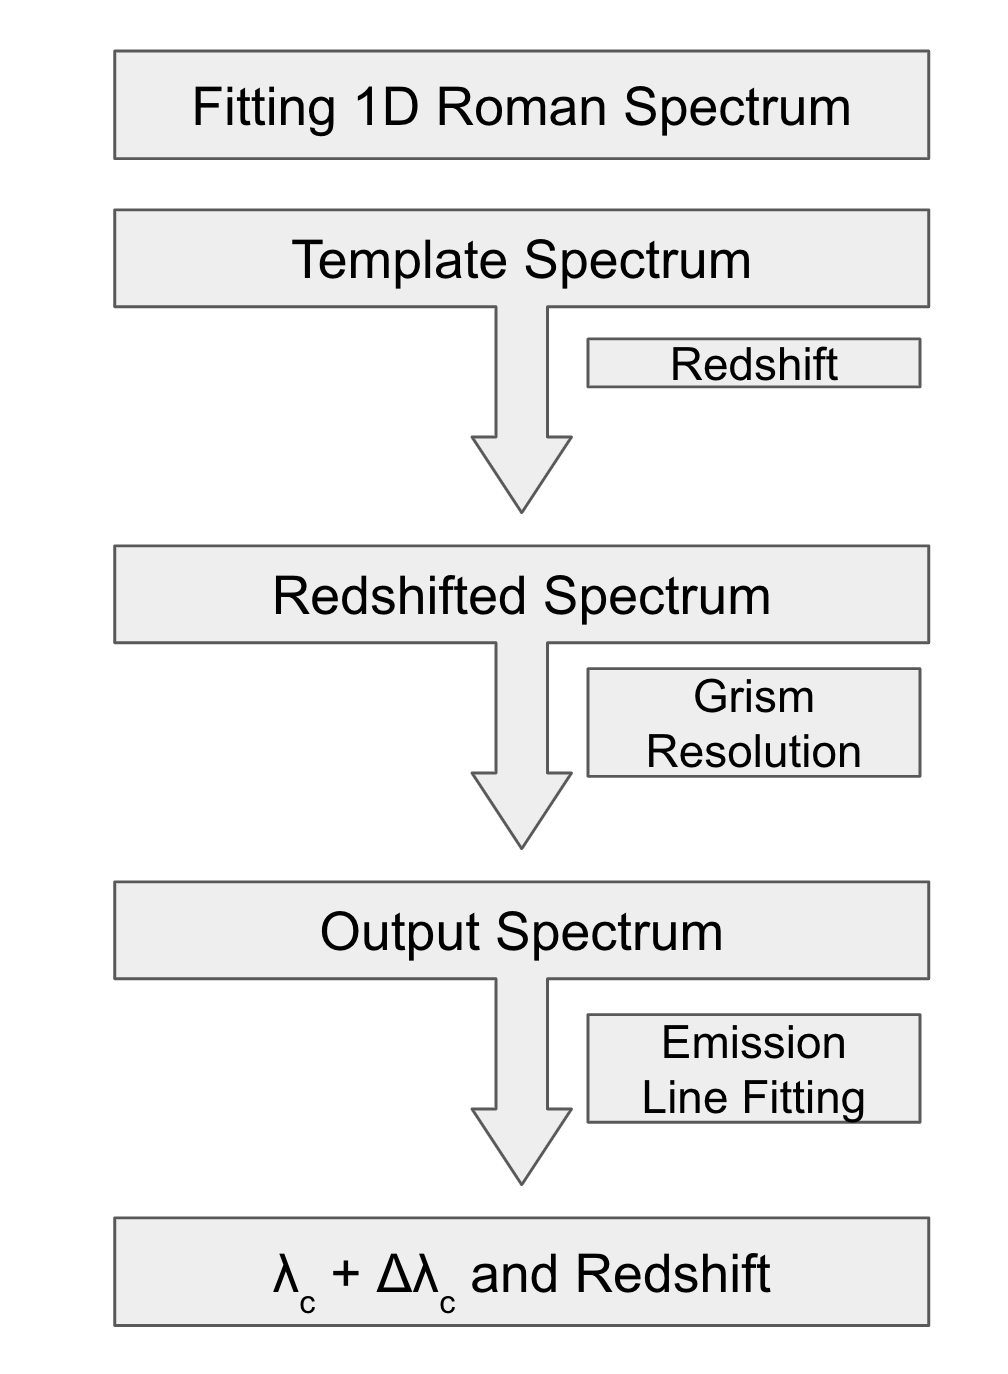

In [3]:
display.Image(path + 'notebookflowchart.png', width = 400, height = 300)

# Goals: 
## - How to transform template spectra into Roman Grism spectra
## - Be able to estimate redshift and line fluxes using the methods here

# **Part 1: Transforming Template Spectra into Grism Resolution**



# Preliminaries: Function definitions


In [7]:
#Function that sets the input spectrum to z = 0 and redshifts it to a z of the user's choosing 

def deredshift_and_redshift(wavelength, flux, original_redshift, new_redshift): 

    #de-redshift the spectra
    rest_wav = wavelength / (1 + original_redshift)
    rest_flux = flux * (1 + original_redshift)
    
    # Redshift the spectrum
    obs_wav = rest_wav * (1 + new_redshift)
    obs_flux = rest_flux / (1 + new_redshift)
    
    # Resample to obtain a constant delta lambda
    resampled_wav = np.arange(obs_wav.min(), obs_wav.max(), 1) #1 angstrom sampling
    resampled_flux = np.interp(resampled_wav, obs_wav, obs_flux)
    
    return resampled_wav, resampled_flux 

In [8]:
#Function to smooth to Roman WFI grism spectral resolution from inputted spectra 

def roman_grism_resolution(wavelength, flux, size_fwhm_arcsec): 
    # Input paramaters:  First is a vector of wavelengths,
    # second is a vector of flux density (erg/cm2/s/Angstrom or similar)
    # Third is the angular size of the source on the sky, in arcseconds
    #     given as full widht at half maxiumum light, 
    #    and here assumed to have a Gaussian spatial profile
    #
    # Step 1: Smooth the spectrum with the instrumental resolution
    fwhm = 20  # FWHM in Angstroms
    sigma = fwhm / 2.354  # Convert FWHM to sigma
    smoothed_flux = gaussian_filter1d(flux, sigma/np.mean(np.diff(wavelength))) #broadens the spectral features while preserving flux
    
    # step 2: Smooth spectrum by source's spatial extent (0.11"/pix)
    #blurs out the object based on its angular size 
    #fwhm = full with half-max, how wide the gaussian is 
    
    # size_fwhm_arcsec= 0.3 # reasonable for high-z galaxy but now passed in as a function argument.
    
    size_sigma_pixel=size_fwhm_arcsec / 2.354 / .11 * 11 #sigma and fwhm are related by the factor of 2.354, converting arcsec to pixels 
    smoothed_flux2 = gaussian_filter1d(smoothed_flux, size_sigma_pixel) #smooth out flux 
    
    # Step 3: Resample onto a grid with 11 Angstrom sampling
    new_wav = np.arange(wavelength.min(), wavelength.max(), 11)  # Roman's wavelength grid
    new_flux = np.interp(new_wav, wavelength, smoothed_flux2)
    
    return new_wav, new_flux, smoothed_flux, smoothed_flux2

## Load and read a template spectrum (in this example,a strong emission line galaxy)

In [10]:
data=np.loadtxt(path + '/spectra/template_emlinegalaxy_spec.txt') 

The `np.loadtxt()` function reads the file containing the spectrum data.

The file "template_emlinegalaxy_spec" is a plain text file with 2 columns:
    Column 1 for wavelenth in Angstroms and 
    Column 2 for flux density in erg/cm2/s/Angstrom.

The data is stored as a 2D array where each row corresponds to a single data point.


In [12]:
wav = data.T[0]     # Get the wavelength.

In [13]:
flux=data.T[1]      # get the flux density

In the above 2 cells:   
data.T transposes the array, swapping rows and columns.
The first column (index 0) corresponds to the wavelength in Angstroms.
The second column (index 1) corresponds to the flux values, which measure the brightness at each wavelength.

These are extracted and stored in the variables wav and flux.

Here is what this spectrum looks like in its restframe

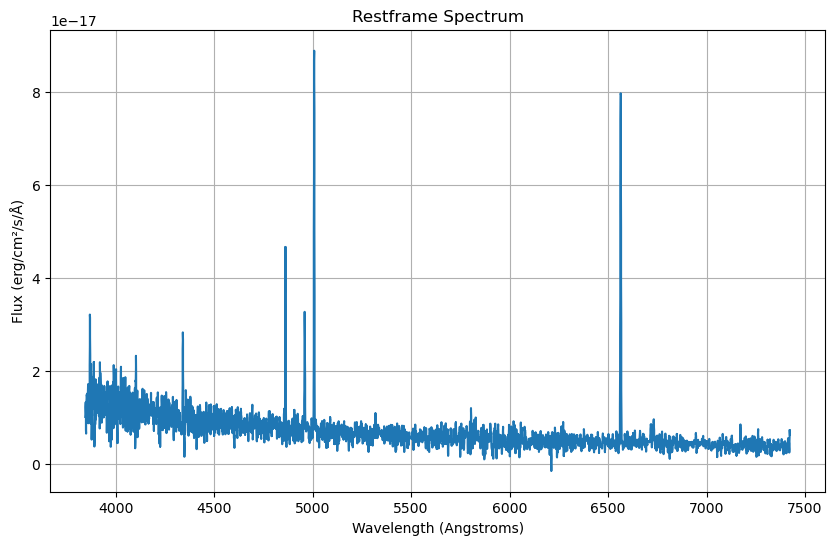

In [16]:
'''The template spectrum we are starting from is given in rest wavelength'''

rest_flux = flux
rest_wav = wav

plt.figure(figsize = (10,6))
plt.plot(rest_wav, rest_flux)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/cm²/s/Å)')
plt.title("Restframe Spectrum")
plt.grid()
plt.show()

## Redshift the template spectrum to redshift z=1.6
This will place prominent rest-optical emission lines in the wavelength range of the Roman WFI Grism.

In [18]:
# Now redshift the spectrum to z=1.6, using the functions defined above.

redshifted_wav, redshifted_flux = deredshift_and_redshift(wav, flux, 0, 1.6)


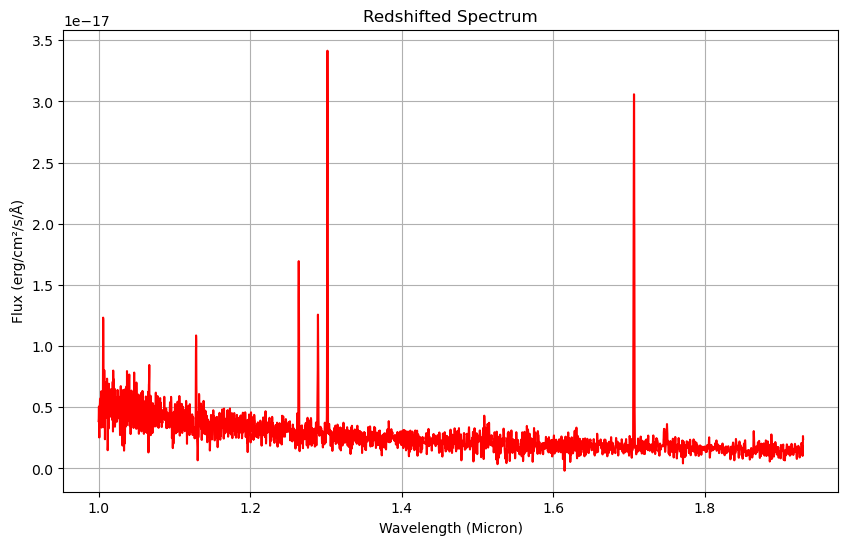

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(redshifted_wav/1e4, redshifted_flux, color='red')  # converting wavelength from Angstroms to microns
plt.xlabel('Wavelength (Micron)')
plt.ylabel('Flux (erg/cm²/s/Å)')
plt.title("Redshifted Spectrum")
plt.grid()
plt.show()

## Degrade the redshifted spectrum to Roman WFI grism resolution

In [21]:
# Smooth to effective Roman grism spectral resolution,
# here assuming 0.3 arcsecond full-width-half-max angular size for the object
sim_roman_wav, sim_roman_flux, smoothed, smoothed2 = roman_grism_resolution(redshifted_wav, redshifted_flux, 0.3)

### Here you can see how the spectrum compares at each step

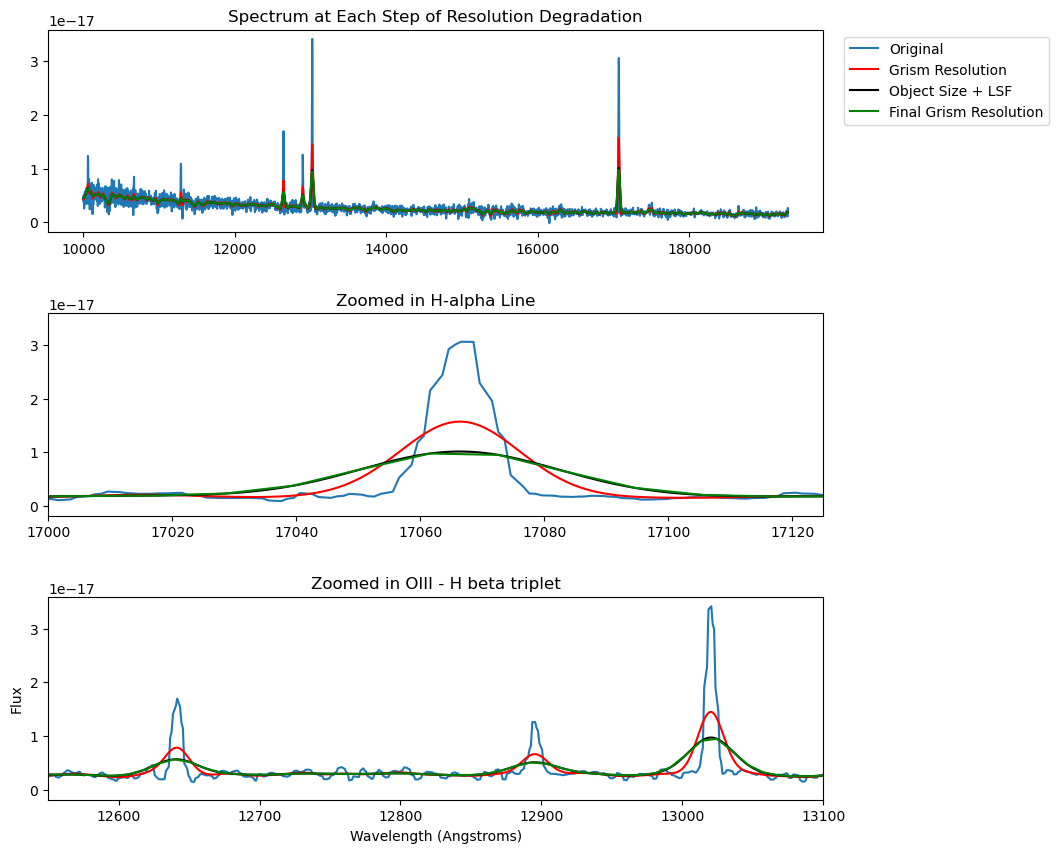

In [90]:
fig, axs = plt.subplots(ncols = 1, nrows = 3, figsize = (10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
axs[0].set_title("Spectrum at Each Step of Resolution Degradation")
axs[0].plot(redshifted_wav, redshifted_flux, label = 'Original')
axs[0].plot(redshifted_wav, smoothed, label = 'Grism Resolution', color = 'red')
axs[0].plot(redshifted_wav, smoothed2, label = 'Object Size + LSF', color = 'black')
axs[0].plot(sim_roman_wav, sim_roman_flux, label = 'Final Grism Resolution', color = 'green')

axs[1].set_title("Zoomed in H-alpha Line")
axs[1].plot(redshifted_wav, redshifted_flux, label = 'Original')
axs[1].plot(redshifted_wav, smoothed, label = 'Grism Resolution', color = 'red')
axs[1].plot(redshifted_wav, smoothed2, label = 'Object Size + LSF', color = 'black')
axs[1].plot(sim_roman_wav, sim_roman_flux, label = 'Final Grism Resolution', color = 'green')
axs[1].set_xlim(17000, 17125)

axs[2].set_title("Zoomed in OIII - H beta triplet")
axs[2].plot(redshifted_wav, redshifted_flux, label = 'Original')
axs[2].plot(redshifted_wav, smoothed, label = 'Grism Resolution', color = 'red')
axs[2].plot(redshifted_wav, smoothed2, label = 'Object Size + LSF', color = 'black')
axs[2].plot(sim_roman_wav, sim_roman_flux, label = 'Final Grism Resolution', color = 'green')
axs[2].set_xlim(12550, 13100)
axs[0].legend(bbox_to_anchor=(1.3, 1), loc = 'upper right')

plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.show()

# **Part 2: Fitting H-$\alpha$ line to Roman Spectra**

## Function Definitions

In [26]:
# Define a Gaussian function
def gaussian(wavelength, amplitude, mean, sigma, cont):
    return amplitude * np.exp(-0.5 * ((wavelength - mean) / sigma) ** 2) + cont


Notes: This function models a Gaussian curve with parameters:

amplitude: Peak height of the Gaussian.

mean: Central wavelength of the Gaussian.

sigma: Dispersion (width) of the Gaussian.

cont: Continuum

Function to Calculate Line Flux

In [28]:
# Function to calculate line flux (integral of Gaussian)
def calculate_line_flux(amplitude, sigma):
    return amplitude * sigma * np.sqrt(2 * np.pi)

The integral of a Gaussian curve gives the line flux. 

This formula calculates the total flux under the Gaussian using the amplitude and sigma

# Fitting a curve for emission lines

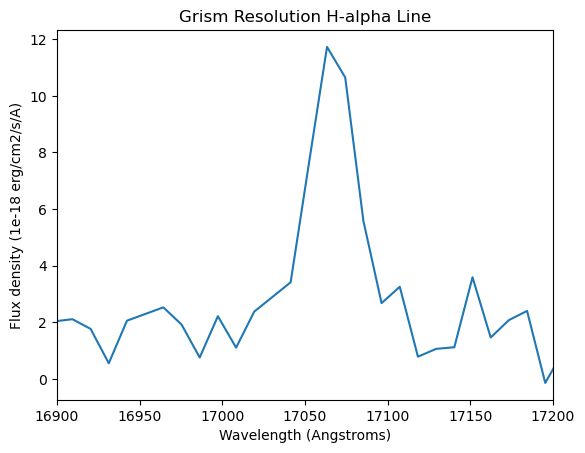

In [31]:
data1=np.loadtxt(path + 'spectra/roman_emission_line_galaxy1_v3.txt')
roman_wav = data1.T[0]
roman_flux = data1.T[1] * 1e18   # To avoid underflow errors in Python
roman_flux_err = data1.T[2] * 1e18 # Better keep the error bars in same unit as data ;-)

plt.figure()
plt.plot(roman_wav, roman_flux)
plt.ylabel('Flux density (1e-18 erg/cm2/s/A)')
plt.xlabel('Wavelength (Angstroms)')
plt.title('Grism Resolution H-alpha Line')
plt.xlim(16900, 17200)
#plt.ylim(1.2e-18, 3.0e-18)
plt.show()

## Step 1: Mask data to only include H-alpha

In [33]:
# You might need to mask or restrict the wavelength range around the line
mask = (roman_wav > 16900) & (roman_wav < 17200)  # Adjust to your line's region

### Step 2: Use `curve_fit` 

In [35]:
# Define an initial guess for fitting
initial_guess = [10, 17075, 15, 1]

Notes: Provide an initial guess for the Gaussian parameters:

10: Approximate amplitude.

17075: Approximate mean (central wavelength).

15: Approximate sigma (dispersion).

1.0: Approximate continuum flux in units of 10^(-18) erg/cm^2/s/Angstrom

In [37]:
bounds = ([0, 16900, 1, 0], [np.inf, 17200, 100, np.inf])  # Adjust as necessary

We need to put bounds as it is a noisy spectra. 
If we don't put bounds, the fit will not converge

In [39]:
# Perform the fit with bounds.
# We use the scipy.curve_fit package.
popt, pcov = curve_fit(
    gaussian, 
    roman_wav[mask], 
    roman_flux[mask], 
    p0=initial_guess, 
    bounds=bounds, 
    sigma=roman_flux_err[mask], 
    absolute_sigma=True
)

In [40]:
amplitude_fit, mean_fit, sigma_fit, cont_fit = popt

Assign the best-fit parameter values to respective variables for clarity.

In [42]:
line_flux = calculate_line_flux(amplitude_fit, sigma_fit)

Notes: Compute the line flux using the fitted amplitude and sigma.

In [44]:
print(f"Fit Parameters:")
print(f"  Amplitude: {amplitude_fit*1e-18:.2e} erg/cm^2/s/Angstrom")
print(f"  Central wavelength: {mean_fit:.4f} Angstrom")
print(f"  Line width (sigma): {sigma_fit:.4f} Angstroms")
print(f"  Cont: {cont_fit*1e-18:.2e} erg/cm^2/s/Angstrom")
print(f"Line Flux: {line_flux*1e-18:.2e} erg/cm^2/s")

Fit Parameters:
  Amplitude: 1.02e-17 erg/cm^2/s/Angstrom
  Central wavelength: 17066.6597 Angstrom
  Line width (sigma): 13.6445 Angstroms
  Cont: 1.78e-18 erg/cm^2/s/Angstrom
Line Flux: 3.50e-16 erg/cm^2/s


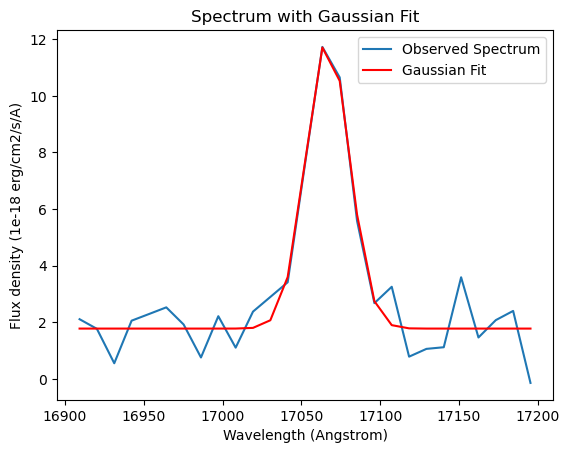

In [45]:
# Extract fit parameters

# Print fit parameters and line flux


# Plot the fit
plt.plot(roman_wav[mask], roman_flux[mask], label="Observed Spectrum")
plt.plot(
    roman_wav[mask],
    gaussian(roman_wav[mask], *popt),
    label="Gaussian Fit",
    color="red",
)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel('Flux density (1e-18 erg/cm2/s/A)')
plt.title("Spectrum with Gaussian Fit")
plt.legend()
plt.show()


In [46]:
n_iter = 100

Define the number of Monte Carlo iterations. 

This determines how many times the flux data will be perturbed and refitted

In [48]:
amplitude_dist, mean_dist, sigma_dist, flux_dist = [], [], [], []


Create empty lists to store the results of each iteration for the fitted parameters 

(amplitude, mean, sigma) and the computed flux.

In [50]:

for _ in range(n_iter): # Repeat the following steps n_iter times to generate a distribution of fitted parameters.
    # Perturb the flux values
    
    perturbed_flux = roman_flux[mask] + np.random.normal(0, roman_flux_err[mask], size=roman_flux[mask].shape) # 
# Add random noise to the observed flux values.np.random.normal(0, roman_flux_err[mask], size=...) generates random Gaussian noise with a mean of 0 and standard deviation equal to the flux uncertainty (roman_flux_err[mask]).This simulates how the flux values might vary due to measurement errors.
    
    # Refit the Gaussian
    popt_iter, _ = curve_fit(gaussian, roman_wav[mask], perturbed_flux, p0=initial_guess) # Perform Gaussian fitting on the perturbed flux data using curve_fit.
#  popt_iter: Optimal parameters (amplitude, mean, sigma, and baseline) for the current iteration.
    
    # Extract the parameters and calculate the flux
    amplitude_iter, mean_iter, sigma_iter, baseline_iter = popt_iter
    flux_iter = calculate_line_flux(amplitude_iter, sigma_iter)

    # Extract the best-fit parameters for this iteration.
    #Compute the line flux using the same formula as before (calculate_line_flux).
    
    # Store the parameters
    amplitude_dist.append(amplitude_iter)
    mean_dist.append(mean_iter)
    sigma_dist.append(sigma_iter)
    flux_dist.append(flux_iter)

    # Append the fitted parameters and flux value from this iteration to their respective lists

# Calculate uncertainties
amplitude_err = np.std(amplitude_dist)
mean_err = np.std(mean_dist)
sigma_err = np.std(sigma_dist)
flux_err = np.std(flux_dist)

# Use the standard deviation (np.std) of the distributions to quantify the uncertainty for each parameter.
#The variability across iterations reflects the uncertainty in the fitting process due to the flux noise

print("\nMonte Carlo Results (Uncertainties):")
print(f"Amplitude: {amplitude_fit:.3f} ± {amplitude_err:.3f} (1e-18 erg/cm2/s/Angstrom)")
print(f"Central wavelength: {mean_fit:.3f} ± {mean_err:.3f} Angstrom")
print(f"Line dispersion: {sigma_fit:.3f} ± {sigma_err:.3f} Angstrom")
print(f"Line Flux: {line_flux*1e-18:.3e} ± {flux_err*1e-18:.3e} erg/cm2/s")

# Print the best-fit values (amplitude_fit, mean_fit, sigma_fit, line_flux) along with their uncertainties (amplitude_err, mean_err, sigma_err, flux_err).
#The uncertainties indicate the level of confidence in the fitted parameters based on the data's noise level.


Monte Carlo Results (Uncertainties):
Amplitude: 10.238 ± 0.691 (1e-18 erg/cm2/s/Angstrom)
Central wavelength: 17066.660 ± 1.119 Angstrom
Line dispersion: 13.645 ± 1.199 Angstrom
Line Flux: 3.502e-16 ± 2.656e-17 erg/cm2/s


In [51]:
H_alpha_rest = 6562.819 # This is the rest-frame wavelength of the Hα line in Angstroms. It is a known constant.
H_alpha_obs= popt[1] # he observed wavelength of the Hα line (H_alpha_obs) is extracted from the Gaussian fitting results (popt[1]), which corresponds to the fitted mean of the Gaussian.


In [52]:
Redshift = (H_alpha_obs - H_alpha_rest)/H_alpha_rest
# This equation calculates how much the wavelength has shifted due to the object's motion (e.g., from the expansion of the universe)

In [53]:
Redshift_err=mean_err/mean_fit
# The uncertainty in the redshift is proportional to the fractional uncertainty in the observed wavelength (mean_err / mean_fit).
#mean_err: Standard deviation of the mean from the Monte Carlo simulation.
#mean_fit: Fitted mean wavelength from the Gaussian

In [54]:
print("The redshift is", np.round(Redshift,5))
print("The redshift error is", np.round(Redshift_err,6))


The redshift is 1.60051
The redshift error is 6.6e-05


# Exercise - Try it on your own! 

### We provide five simulated Roman grism galaxy spectra in the `spectra/galaxy` folder in the GitHub distribution.   
### Find their redshifts, redshift errors, and line fluxes for as many strong lines as you feel like! 

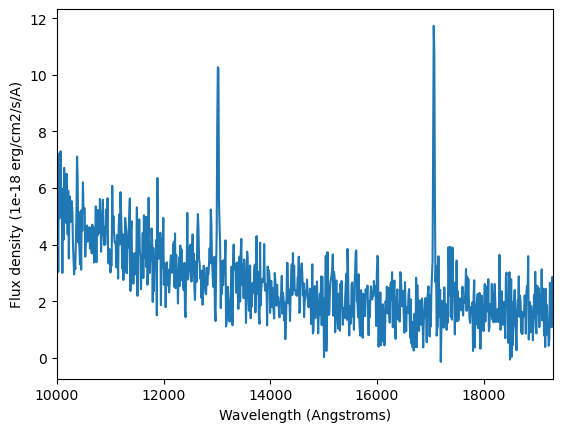

In [56]:
'''To get a feel for these, you may uncomment the different load lines below and look at the spectra'''
# Choose one...  and then do the rest!

data1=np.loadtxt(path + 'spectra/roman_emission_line_galaxy1_v3.txt')
#data1=np.loadtxt(path + 'spectra/roman_emission_line_galaxy2_v3.txt')
#data1=np.loadtxt(path + 'spectra/roman_emission_line_galaxy3_v3.txt')
#data1=np.loadtxt(path + 'spectra/roman_emission_line_galaxy4_v3.txt')
#data1=np.loadtxt(path + 'spectra/roman_emission_line_galaxy5_v3.txt')

roman_wav = data1.T[0]
roman_flux = data1.T[1] * 1e18   # To avoid underflow errors in Python
roman_flux_err = data1.T[2] * 1e18 # Better keep the error bars in same unit as data ;-)


plt.figure()
plt.plot(roman_wav, roman_flux)
plt.ylabel('Flux density (1e-18 erg/cm2/s/A)')
plt.xlabel('Wavelength (Angstroms)')
plt.xlim(10000, 19300)
#plt.ylim(1.2e-18, 3.0e-18)
plt.show()